#Transfer Learning :Fine - Tuning

In [2]:
/

()

##Importing helper function 


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-27 18:36:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2022-02-27 18:36:59 (8.44 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
#import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback , plot_loss_curves , unzip_data , walk_through_dir

#Let's get some data

this time we re going to see how we can use the pretrained models
within tf.keras

In [5]:
!wget http://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-02-27 18:37:02--  http://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  63.4MB/s    in 2.5s    

2022-02-27 18:37:05 (63.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
#check out how many images and subdirectories are there
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [7]:
#Create training and test directory paths

train_dir = "10_food_classes_10_percent/train"
test_dir ="10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
                            directory = train_dir,
                            label_mode="categorical",
                            image_size = IMG_SIZE,
                            batch_size= BATCH_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size= IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
#checking out the class names of our dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images , labels in train_data_10_percent.take(1):
  print(images , labels)
  #trying out the images

tf.Tensor(
[[[[231.37245   228.37245   209.37245  ]
   [230.54591   227.54591   210.54591  ]
   [234.46939   231.46939   214.89796  ]
   ...
   [239.63263   235.63263   223.63263  ]
   [237.33167   233.33167   221.33167  ]
   [240.97446   236.97446   225.97446  ]]

  [[226.73979   223.73979   206.73979  ]
   [237.2143    234.2143    217.2143   ]
   [230.54591   227.54591   210.97449  ]
   ...
   [239.15816   235.15816   223.15816  ]
   [241.79085   237.79085   225.79085  ]
   [242.95909   238.95909   227.95909  ]]

  [[231.56633   228.56633   211.9949   ]
   [238.66837   235.66837   219.09694  ]
   [236.98468   233.98468   218.98468  ]
   ...
   [236.21927   232.21927   220.21927  ]
   [235.54088   231.54088   219.54088  ]
   [237.22948   233.22948   222.22948  ]]

  ...

  [[233.47969   235.47969   214.26543  ]
   [230.19896   232.19896   210.9847   ]
   [227.56638   229.56638   208.35211  ]
   ...
   [211.22464   220.60725   188.41348  ]
   [212.21426   221.48466   189.65816  ]
   [2

#Model 0: Building a transfer learning model using the keras functional API

In [12]:
#1. Create the base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model(so the underlying pre-trained patterns aren't update during training)
base_model.trainable = False

#3.create inputs in our model
inputs = tf.keras.layers.Input(shape=(224, 224,3) , name="input_layer")

#4. normalizing the data
#x= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

#6.Average pool the output of the base model (aggregate all the important information , reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GLobalAveragePOOL2D : {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax" , name="output_layers")(x)

#8. Combine the input with the output into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Combine for the model 
model_0.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10. Fit the model with data 
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks =[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name= " 10_percent_feature_extraction")] )

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GLobalAveragePOOL2D : (None, 1280)
Saving TensorBoard log files to: transfer_learning/ 10_percent_feature_extraction/20220227-183713
Epoch 1/5
24/24 [==============================] - 91s 4s/step - loss: 1.9010 - accuracy: 0.4147 - val_loss: 1.3577 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - 82s 3s/step - loss: 1.1574 - accuracy: 0.7280 - val_loss: 0.9381 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - 84s 4s/step - loss: 0.8354 - accuracy: 0.8200 - val_loss: 0.7434 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - 85s 4s/step - loss: 0.6941 - accuracy: 0.8307 - val_loss: 0.6635 - val_accuracy: 0.8158
Epoch 5/5
24/24 [==============================] - 81s 3s/step - loss: 0.5930 - accuracy: 0.8667 - val_loss: 0.6031 - val_accuracy: 0.8339


In [13]:
model_0.evaluate(test_data)

79/79 [==============================] - 152s 2s/step - loss: 0.6126 - accuracy: 0.8368


[0.6125738024711609, 0.8367999792098999]

In [14]:
#Check the layers in our model 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
#How about we get a  summary of the model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


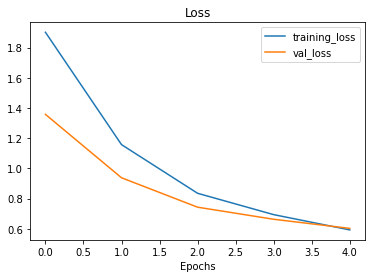

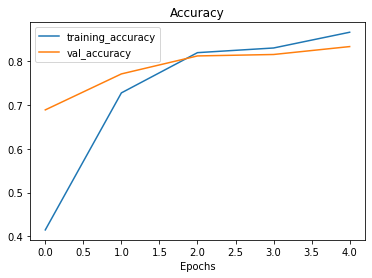

In [17]:
plot_loss_curves(history_10_percent)
#plot loss

In [18]:
#Add data augmentation right into the model 


In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-02-27 18:48:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  50.9MB/s    in 2.5s    

2022-02-27 18:48:51 (50.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There a

In [21]:
import tensorflow as tf # integrating tensorflow
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 

#Create data augmentedd stage  with a horiztontal flipping , rotation , zoom, est
data_augmentation = keras.Sequential ([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.3),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                #preprocessing.Rescale(1./255)#kkep th emodel like resnet but effectivenet

], name ="data_augmentation") 


#visualize the data random image 

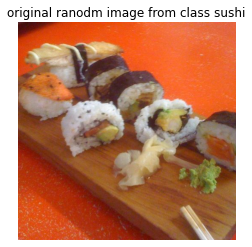

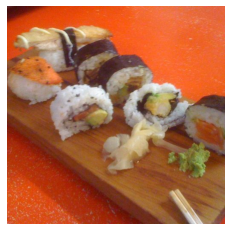

In [23]:
#view a random image and compare  it to the augment image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" +  target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

#Read in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"original ranodm image from class {target_class}")
plt.axis(False);

#Now let's plot our augmented random image 
augmented_img = data_augmentation(tf.expand_dims(img ,axis=0))
plt.figure()
plt.axis(False);
plt.imshow(tf.squeeze(augmented_img)/255.)

In [24]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

#Model 1: Feature extraction tramsfer learning only on 1% of the data

In [25]:
#Setup input shape and setup the base model
input_shape = (224 , 224 , 3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

#Create input layer 
inputs = layers.Input(shape = input_shape , name = "input_layers")

#add in Data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#Give base_model the input (after augmentatiojn ) and don't train it 
x = base_model(x , training = False)

#Pool output feature of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put a dense layer on as the output 
outputs = layers.Dense(10, activation = "softmax" , name= "output_layer")(x)

#Make a model using the input and output 
model_1 = keras.Model(inputs, outputs)

#compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#fit the model 
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                #track the model training logs
                                callbacks=[create_tensorboard_callback(dir_name = "transfer_learning", 
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220227-184856
Epoch 1/5
3/3 [==============================] - 54s 23s/step - loss: 2.3802 - accuracy: 0.1000 - val_loss: 2.2497 - val_accuracy: 0.1628
Epoch 2/5
3/3 [==============================] - 45s 22s/step - loss: 2.0998 - accuracy: 0.2429 - val_loss: 2.1260 - val_accuracy: 0.2434
Epoch 3/5
3/3 [==============================] - 45s 21s/step - loss: 1.9650 - accuracy: 0.3857 - val_loss: 2.0181 - val_accuracy: 0.3158
Epoch 4/5
3/3 [==============================] - 43s 20s/step - loss: 1.7593 - accuracy: 0.5857 - val_loss: 1.9078 - val_accuracy: 0.4030
Epoch 5/5
3/3 [==============================] - 43s 20s/step - loss: 1.6156 - accuracy: 0.6571 - val_loss: 1.8293 - val_accuracy: 0.4539


In [26]:
#check the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
#evaluate on the full test data set 
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 156s 2s/step - loss: 1.8332 - accuracy: 0.4608


[1.8332124948501587, 0.4607999920845032]

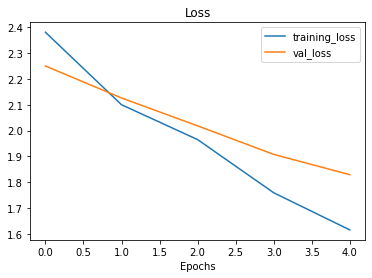

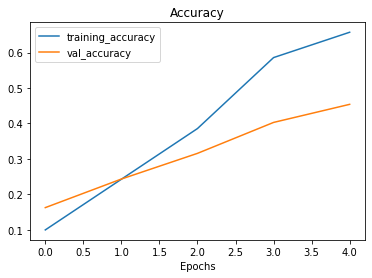

In [28]:
plot_loss_curves(history_1_percent)

###Model :2 only theory done 

#Model_3 :Fine tunning 

In [29]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
#Data downloaded. Let's create the dataloaders.

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220227-185643
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0216 - accuracy: 0.3400
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 113s 4s/step - loss: 2.0216 - accuracy: 0.3400 - val_loss: 1.5419 - val_accuracy: 0.6135
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3696 - accuracy: 0.6680
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 95s 4s/step - loss: 1.3696 - accuracy: 0.6680 - val_loss: 1.1137 - val_accuracy: 0.7171
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0768 - accuracy: 0.7213
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 132s 6s/step - loss: 1.0768 - accuracy: 0.7213 - val_loss: 0.9281 - val_accuracy: 0.7500
Epoch 4/

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 202s 3s/step - loss: 0.7159 - accuracy: 0.8052


In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb2fccf2110> True
<keras.engine.sequential.Sequential object at 0x7fb2fcc3b810> True
<keras.engine.functional.Functional object at 0x7fb2fc753590> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb2fcc3b9d0> True
<keras.layers.core.dense.Dense object at 0x7fb2fa48ca50> True


In [ ]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i , layer.name , layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in the our base_model
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# to begin fine tuning , lets det last 10 layers to trainable to true 
base_model.trainable  =True 

#Freeze all the layers except the last 10 
for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile the changes we have made in the model
model_2.compile(loss="categorical_crossentropy", 
                optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#fine tune the model 5 epochs 
fine_tune_epochs = initial_epochs +5 

#Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],#start training from the last 5 epochs),
                                               callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")]
                                              )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220227-191016
Epoch 5/10
24/24 [==============================] - 160s 6s/step - loss: 0.7055 - accuracy: 0.7907 - val_loss: 0.6050 - val_accuracy: 0.7961
Epoch 6/10
24/24 [==============================] - 153s 6s/step - loss: 0.5579 - accuracy: 0.8267 - val_loss: 0.5732 - val_accuracy: 0.8059
Epoch 7/10
24/24 [==============================] - 155s 7s/step - loss: 0.5018 - accuracy: 0.8493 - val_loss: 0.5549 - val_accuracy: 0.8076
Epoch 8/10
24/24 [==============================] - 123s 5s/step - loss: 0.4713 - accuracy: 0.8453 - val_loss: 0.5616 - val_accuracy: 0.8158
Epoch 9/10
24/24 [==============================] - 154s 7s/step - loss: 0.4055 - accuracy: 0.8747 - val_loss: 0.5609 - val_accuracy: 0.8109
Epoch 10/10
24/24 [==============================] - 120s 5s/step - loss: 0.3877 - accuracy: 0.8733 - val_loss: 0.5555 - val_accuracy: 0.8125


In [ ]:
#Evaluate the fine-tuned model 
def compare_history(original_history , new_history , initial_epochs =5):
  """
  Compare the model
  """
  #Get the history measurement 
  acc= original_history.history["accuracy"]
  loss =  original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #compibe the original history 
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["accuracy"]
  total_val_loss = val_loss + new_history.history["loss"]

  #Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc , label="Trainning Accuracy")
  plt.plot(total_val_acc , label="Trainning Loss")
  plt.plot([initial_epochs-1 , initial_epochs-1] , plt.ylim() , label="Start Fine tuning")
  plt.legend(loc="lower right")

  #Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss , label="Trainning loss")
  plt.plot(total_val_loss , label="Trainning Loss")
  plt.plot([initial_epochs-1 , initial_epochs-1] , plt.ylim() , label="Start Fine tuning")
  plt.legend(loc="upper right")

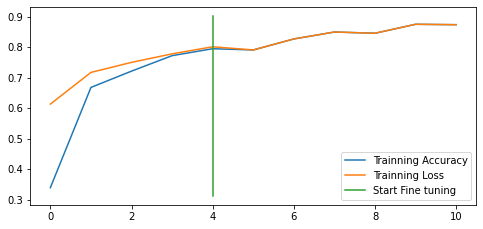

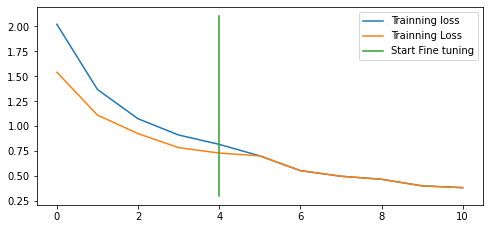

In [ ]:
compare_history(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs= 5)


#Model 4: Doing same thing this time using 100% of our data

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"


--2022-02-27 19:28:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   152MB/s    in 3.2s    

2022-02-27 19:28:40 (152 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [ ]:
#Setup data inputs
import tensorflow as tf
import os
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode= "categorical", 
                                                                                 image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#evaluate the model 2
model_2.evaluate(test_data)

79/79 [==============================] - 177s 2s/step - loss: 0.5285 - accuracy: 0.8232


[0.5285158157348633, 0.823199987411499]

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 195s 2s/step - loss: 0.7159 - accuracy: 0.8052


[0.7159098982810974, 0.8051999807357788]

Alright , the previous steps might seem quite confusing but all weve done is train a feature extraction transfer learning model for 5 epochs on 10% data with data augment
and we saved the model weights using MOdelcheckpoint 



In [ ]:
#check the tunable layer
for layer_number , layer in enumerate(model_2.layers):
  print(layer_number ,layer.name , layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
model_2.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr =0.0001),
                metrics = ["accuracy"])

fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = initial_epochs + 5 
histor